# Задание из четвёртой лабы

Обучите один из алгоритмов классификации из библиотеки sklearn. Объяснять принцип работы классификатора в этой лабораторной не требуется

1. Выберите один из датасетов первой лабораторной


2. Найдите в данных признак, который будете предсказывать

    Если это категория, то у неё должно быть от 2 до 10 значений (например колонка species в датасете миграции птиц содержит 3 категории)

    Если признак количественный, то его нужно дискретизировать (например для популярности трека в датасете spotify можно разделить треки на 3 категории: 0-20 - популярные, 21-50 - обычные, 51 - 100 - непопулярные). Полученную категорию записать в датафрейм как отдельную колонку


3. Выделите признаки для предсказания

    Используйте от 2 до 5 количественных признаков для предсказания целевой переменной


4. Проверьте нормальность количественных признаков

    Используйте статистический тест из лекции. Если распределение является лог-нормальным, логарифмируйте его и проверьте на нормальность

    Как минимум 1 из признаков должен быть нормальным


5. Покажите качество предсказания модели с помощью метрик

    Метрика должна учитывать баланс классов в датасете

Импорты

In [1]:
import numpy as np
import pandas as pd

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Utils
from scipy.stats import normaltest
from sklearn.model_selection import cross_val_score

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

Подготовим датасет.

In [2]:
df = pd.read_csv('./Data/user_data.csv')
df.head()

,name,planning,watched,completed,days_watched,dropped,episodes_watched,mean_score,on_hold,plan_to_watch,rewatched,total_entries,watching,birthday,gender,joined,last_online,location,favorites,genre_count
0,-0,"[{'mal_id': 39764, 'title': 'Detective Conan M...","[{'title': '1', 'mal_id': 29978, 'score': 6, '...",467,181.6,0,11160,7.74,0,7,0,477,3,NaN,NaN,2017-09-19T00:00:00+00:00,2020-09-25 11:03:22+00:00,NaN,"{'anime': [], 'characters': [], 'people': []}","{'Action': 153, 'Adventure': 162, 'Cars': 5, '..."
1,-Droid-,"[{'mal_id': 6408, 'title': '""Bungaku Shoujo"" M...","[{'title': '11eyes', 'mal_id': 6682, 'score': ...",1125,263.3,4,16195,7.80,4,1131,53,2271,7,1930-01-07T00:00:00+00:00,Male,2013-09-07T00:00:00+00:00,2020-09-17 21:07:00+00:00,MA,"{'anime': [{'mal_id': 237, 'title': 'Koukyoush...","{'Action': 447, 'Adventure': 186, 'Cars': 1, '..."
2,-Hentai,"[{'mal_id': 39783, 'title': '5-toubun no Hanay...","[{'title': '3-gatsu no Lion', 'mal_id': 31646,...",887,270.4,60,16189,7.36,9,88,8,1070,26,1991-11-05T00:00:00+00:00,Male,2014-05-19T00:00:00+00:00,2020-09-21 19:11:28+00:00,UAE - Sharjah,"{'anime': [{'mal_id': 31933, 'title': 'JoJo no...","{'Action': 418, 'Adventure': 210, 'Cars': 1, '..."
3,-Jens,"[{'mal_id': 31646, 'title': '3-gatsu no Lion'}...","[{'title': '07-Ghost', 'mal_id': 5525, 'score'...",102,17.8,0,1093,6.81,8,403,0,518,5,NaN,NaN,2020-06-11T00:00:00+00:00,2020-09-24 14:06:00+00:00,Fish tank. I'm stuck.,"{'anime': [{'mal_id': 205, 'title': 'Samurai C...","{'Action': 36, 'Adventure': 9, 'Cars': 0, 'Com..."
4,-Kano,"[{'mal_id': 34777, 'title': '91 Days: Toki no ...","[{'title': '3-gatsu no Lion', 'mal_id': 31646,...",193,65.2,25,3961,6.92,32,70,2,325,5,NaN,NaN,2015-08-12T00:00:00+00:00,2020-09-26 01:29:32+00:00,NaN,"{'anime': [], 'characters': [], 'people': []}","{'Action': 84, 'Adventure': 25, 'Cars': 0, 'Co..."


In [3]:
df.isnull().sum()

name                  0
planning              0
watched               0
completed             0
days_watched          0
dropped               0
episodes_watched      0
mean_score            0
on_hold               0
plan_to_watch         0
rewatched             0
total_entries         0
watching              0
birthday            934
gender              444
joined                0
last_online           0
location            721
favorites             0
genre_count           0
dtype: int64

Удалим нулы, так как в данном случае некорректно будет обучать модель заменяя их на дефолтные значения.
Не трогаем location так как в любом случае не будем ее использовать(невозможно сделать количественным и множество различных значений слишком велико).

In [4]:
df = df.loc[(df['gender'].notnull())]

df = df.loc[(df['birthday'].notnull())]

Добавим новый столбец *age* - возраст пользователя.

In [5]:
df.loc[:, 'age'] = pd.to_datetime(df['birthday'], format='%Y-%m-%d').apply(lambda time: 2021 - time.year)
df.head()

,name,planning,watched,completed,days_watched,dropped,episodes_watched,mean_score,on_hold,plan_to_watch,...,total_entries,watching,birthday,gender,joined,last_online,location,favorites,genre_count,age
1,-Droid-,"[{'mal_id': 6408, 'title': '""Bungaku Shoujo"" M...","[{'title': '11eyes', 'mal_id': 6682, 'score': ...",1125,263.3,4,16195,7.80,4,1131,...,2271,7,1930-01-07T00:00:00+00:00,Male,2013-09-07T00:00:00+00:00,2020-09-17 21:07:00+00:00,MA,"{'anime': [{'mal_id': 237, 'title': 'Koukyoush...","{'Action': 447, 'Adventure': 186, 'Cars': 1, '...",91
2,-Hentai,"[{'mal_id': 39783, 'title': '5-toubun no Hanay...","[{'title': '3-gatsu no Lion', 'mal_id': 31646,...",887,270.4,60,16189,7.36,9,88,...,1070,26,1991-11-05T00:00:00+00:00,Male,2014-05-19T00:00:00+00:00,2020-09-21 19:11:28+00:00,UAE - Sharjah,"{'anime': [{'mal_id': 31933, 'title': 'JoJo no...","{'Action': 418, 'Adventure': 210, 'Cars': 1, '...",30
5,-Kurosawa-,"[{'mal_id': 38749, 'title': 'Blade Runner: Bla...","[{'title': '""0""', 'mal_id': 20707, 'score': 0,...",594,201.2,12,12248,5.42,5,13,...,651,27,2000-05-05T00:00:00+00:00,Male,2016-12-11T00:00:00+00:00,2020-09-20 12:52:00+00:00,Wired,"{'anime': [], 'characters': [], 'people': []}","{'Action': 301, 'Adventure': 152, 'Cars': 3, '...",21
6,-Lethargica-,"[{'mal_id': 6408, 'title': '""Bungaku Shoujo"" M...","[{'title': '00:08', 'mal_id': 28761, 'score': ...",433,51.8,0,3252,5.36,3,666,...,1113,11,1995-03-21T00:00:00+00:00,Female,2017-05-30T00:00:00+00:00,2020-09-25 13:39:32+00:00,NaN,"{'anime': [{'mal_id': 339, 'title': 'Serial Ex...","{'Action': 81, 'Adventure': 64, 'Cars': 0, 'Co...",26
7,-Mahiru-,"[{'mal_id': 19429, 'title': 'Akuma no Riddle'}...",[{'title': '30-pun de Wakaru! Kore made no Lov...,227,44.7,9,2799,7.96,3,81,...,325,5,2003-02-04T00:00:00+00:00,Female,2017-06-15T00:00:00+00:00,2020-09-25 20:23:22+00:00,Hanazono Land,"{'anime': [{'mal_id': 9253, 'title': 'Steins;G...","{'Action': 56, 'Adventure': 20, 'Cars': 0, 'Co...",18


Посмотрим как данные коррелируют друг с другом.

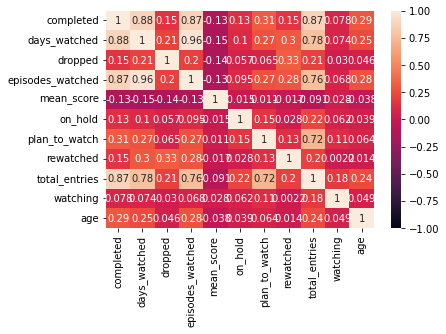

In [6]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True);


Я решил взять столбцы:
 - dropped
 - mean_score
 - on_hold
 - age

и предсказывать пол пользователя.

Удалим все лишнее.

In [7]:
df = df.drop(
    ['name', 'planning', 'watched', 'joined', 'last_online', 'location', 'favorites', 'total_entries', 'completed',
     'rewatched', 'genre_count', 'watching', 'plan_to_watch', 'days_watched', 'episodes_watched', 'birthday'], axis=1)
df.head()

,dropped,mean_score,on_hold,gender,age
1,4,7.80,4,Male,91
2,60,7.36,9,Male,30
5,12,5.42,5,Male,21
6,0,5.36,3,Female,26
7,9,7.96,3,Female,18


Посмотрим общее количество записей.

In [8]:
df.mean_score.count()

1192

Возьмем только ту часть *mean_score* которая является нормальным распределением, а так же запретим *dropped* == 0, тогда *dropped* будет лог-нормальным.

In [9]:
# Можно посмотреть какие и сколько значений мы вырезаем, но занимает кучу места.
# print(np.unique(df.mean_score, return_counts=True))
# print(np.unique(df.dropped, return_counts=True))
# print(np.unique(df.age, return_counts=True))
df = df.loc[(df['mean_score'] > 5) & (df['mean_score'] < 9.5) & (df['dropped'] != 0) & (df['age'] > 10) & (df['age'] < 40)]

Посмотрим на гистограмме что *mean_score* является нормальным.

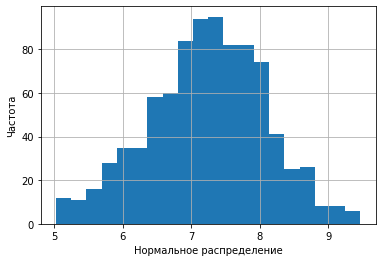

In [10]:
pd.Series(df['mean_score']).hist(bins=20)
plt.xlabel('Нормальное распределение')
plt.ylabel('Частота')
plt.show()

Посмотрим сколько мы вырезали.

In [11]:
df.mean_score.count()

880

*mean_score* - нормальное

In [12]:
for col in df.columns:
    if col == 'gender':
        continue
    print('{} - {}'.format(col, normaltest(df[col])))

dropped - NormaltestResult(statistic=1250.2669316659, pvalue=3.220960031120935e-272)
mean_score - NormaltestResult(statistic=4.304210742842302, pvalue=0.11623917333881044)
on_hold - NormaltestResult(statistic=1876.081810653158, pvalue=0.0)
age - NormaltestResult(statistic=64.33470704970334, pvalue=1.0712624117191466e-14)


*dropped* - лог-нормальное

In [13]:
for col in df.columns:
    if col == 'gender':
        continue
    print('{} - {}'.format(col, normaltest(np.log(df[col]))))

dropped - NormaltestResult(statistic=5.691571579104669, pvalue=0.058088603383628444)
mean_score - NormaltestResult(statistic=31.232142255062726, pvalue=1.652062526621393e-07)
on_hold - NormaltestResult(statistic=nan, pvalue=nan)
age - NormaltestResult(statistic=14.37493218318834, pvalue=0.000756002336187681)


C:\Python\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Python\lib\site-packages\scipy\stats\stats.py:951: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


In [14]:
df['dropped'] = np.log(df['dropped'])

В итоге получаем 2 нормальных распределения.

In [15]:
for col in df.columns:
    if col == 'gender':
        continue
    print('{} - {}'.format(col, normaltest(df[col])))

dropped - NormaltestResult(statistic=5.691571579104669, pvalue=0.058088603383628444)
mean_score - NormaltestResult(statistic=4.304210742842302, pvalue=0.11623917333881044)
on_hold - NormaltestResult(statistic=1876.081810653158, pvalue=0.0)
age - NormaltestResult(statistic=64.33470704970334, pvalue=1.0712624117191466e-14)


На всякий случай перед запуском глянем еще раз на корреляцию.

<AxesSubplot:>

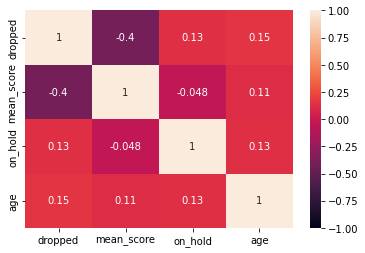

In [16]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)

Все ок, теперь посмотрим на баланс классов.

(array(['Female', 'Male', 'Non-Binary'], dtype=object), array([213, 660,   7], dtype=int64))


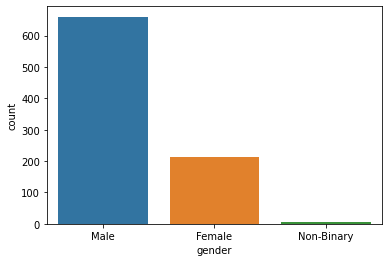

In [17]:
print(np.unique(df.gender, return_counts=True))
sns.countplot(x='gender', data=df);

Правильнее конечно вынести ее в модуль, но для скорости проверки обьявим ее тут.

In [18]:
def run(X_set : np.ndarray, y_set : np.ndarray):


    # Инициализируем алгоритмы с параметрами по-умолчанию
    knn_clf = KNeighborsClassifier()
    svm_clf = SVC()
    forest_clf = RandomForestClassifier()

    # Посчитаем метрику качества используя кросс-валидацию, использую скорер который будет учитывать веса:
    """ ``'weighted'``:
    Calculate metrics for each label, and find their average weighted
    by support (the number of true instances for each label). This
    alters 'macro' to account for label imbalance; it can result in an
    F-score that is not between precision and recall."""

    knn_acc_score = cross_val_score(knn_clf, X_set, y_set, scoring=make_scorer(f1_score, average='weighted')).mean()
    svm_acc_score = cross_val_score(svm_clf, X_set, y_set, scoring=make_scorer(f1_score, average='weighted')).mean()
    forest_acc_score = cross_val_score(forest_clf, X_set, y_set, scoring=make_scorer(f1_score, average='weighted')).mean()

    # knn_acc_score = cross_val_score(knn_clf, X, y).mean()
    # svm_acc_score = cross_val_score(svm_clf, X, y).mean()
    # forest_acc_score = cross_val_score(forest_clf, X, y).mean()

    # Выведем алгоритмы по убыванию качества их работы
    leaderboard = sorted([
        ('KNN', knn_acc_score),
        ('SVC', svm_acc_score),
        ('Forest', forest_acc_score),
    ], key=lambda pair: pair[1], reverse=True)

    print('Leaderboard:')
    for idx, (leader_name, leader_score) in enumerate(leaderboard):
        print(f'{idx + 1}. {leader_name}: {leader_score}')

Посмотрим как оно работает с полом.

In [19]:
X = df.drop(['gender'], axis=1)
y = df['gender']
y = np.squeeze(y)

print(f'Type X: {type(X)}, X shape: {X.shape}')
print(f'Type y: {type(y)}, y shape: {y.shape}')
run(X, y)

Type X: <class 'pandas.core.frame.DataFrame'>, X shape: (880, 4)
Type y: <class 'pandas.core.series.Series'>, y shape: (880,)


C:\Python\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Python\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Python\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Python\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Python\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Leaderboard:
1. KNN: 0.6654926903104534
2. Forest: 0.6553463204893394
3. SVC: 0.6428571428571428


Впринципе сойдет.

Теперь попробуем предсказать возраст.

In [20]:
def get_gender(gender : str) -> int:
    if gender == 'Male':
        return 1
    if gender == 'Female':
        return 2
    return 0

def get_age(age: int) -> str:
    if age < 18:
        return 'underage'
    if age < 35:
        return 'adult'
    return 'mature'

new_df = df
new_df['gender'] = new_df['gender'].apply(get_gender)

new_df['age'] = new_df['age'].apply(get_age)

Баланс такой себе.

(array(['adult', 'mature', 'underage'], dtype=object), array([809,  12,  59], dtype=int64))


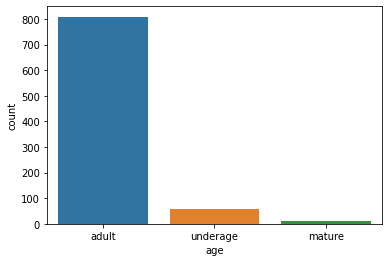

In [21]:
print(np.unique(new_df.age, return_counts=True))
sns.countplot(x='age', data=new_df);

Гендер тоже ни с чем не коррелирует.

<AxesSubplot:>

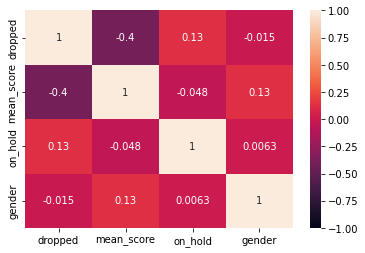

In [22]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)

Результаты конечно хорошие, но даже не смотря на то что скорер учитывает баланс, всеравно вряд ли мы получим таки же хорошие результаты на другом наборе данных.

In [23]:
X = new_df.drop(['age'], axis=1)
y = new_df['age']
y = np.squeeze(y)

print(f'Type X: {type(X)}, X shape: {X.shape}')
print(f'Type y: {type(y)}, y shape: {y.shape}')
run(X, y)

Type X: <class 'pandas.core.frame.DataFrame'>, X shape: (880, 4)
Type y: <class 'pandas.core.series.Series'>, y shape: (880,)


C:\Python\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Python\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Python\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Python\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Python\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Leaderboard:
1. SVC: 0.8806745354622552
2. KNN: 0.8801056453247733
3. Forest: 0.8794279255019714
